# Análise de sentimentos em textos financeiros

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as srn
srn.set()

In [119]:
# bibliotecas para texto
import spacy
import string
import random
import re

# ML
from sklearn.model_selection import train_test_split

In [5]:
base = pd.read_csv('stock_data.csv')
print(base.shape)
base.head()

(5791, 2)


,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [11]:
print(base.info())
base.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Text,5791,5791,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sentiment,5791.0,NaN,NaN,NaN,0.272664,0.962192,-1.0,-1.0,1.0,1.0,1.0


In [6]:
base['Sentiment'].value_counts() 

# +1: positivo
# -1: negativo

 1    3685
-1    2106
Name: Sentiment, dtype: int64

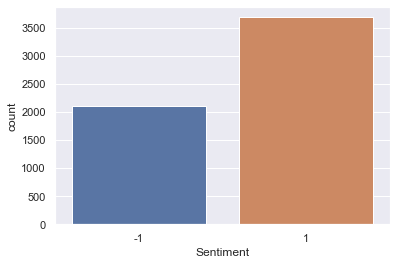

In [9]:
srn.countplot(x=base['Sentiment']);

## Pré-processamento

Temos muitos caracteres especiais que devem ser tratados!

In [26]:
#!python -m spacy download en

In [29]:
pln = spacy.load('en_core_web_sm')
pln

In [33]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
#stop_words

In [64]:
def preprocessamento(texto):
    texto = texto.lower()
    texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[0-9+.0-9+]+", ' ', texto)
    texto = re.sub(f" +", ' ', texto)
    
    documento = pln(texto)
    lista = []
    for token in documento:
        lista.append(token.lemma_)
        
    lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
    lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
    
    return lista

In [68]:
# exemplo
preprocessamento('I will buy 100.0 Apple stocks!!! @apple https://www.twitter.com')

'I buy apple stock'

In [69]:
base['Text'] = base['Text'].apply(preprocessamento)
base.head()

,Text,Sentiment,tamanho
0,kicker watchlist xide tit soq pnk cpw bpz aj t...,1,74
1,user aap movie return fea geed indicator trade...,1,59
2,user I afraid short amzn look like near monopo...,1,77
3,mnta,1,10
4,oi,1,8


## Visualização e exploração

### Número médio de caracteres

In [81]:
base['tamanho'] = base['Text'].apply(len)
print(base.shape)
base.head()

(5791, 3)


,Text,Sentiment,tamanho
0,kicker watchlist xide tit soq pnk cpw bpz aj t...,1,74
1,user aap movie return fea geed indicator trade...,1,59
2,user I afraid short amzn look like near monopo...,1,77
3,mnta,1,4
4,oi,1,2


In [71]:
base['tamanho'].describe()

count    5791.000000
mean       45.140563
std        23.569716
min         0.000000
25%        26.000000
50%        44.000000
75%        62.500000
max       120.000000
Name: tamanho, dtype: float64

In [83]:
# tirando os elementos com tamnho ZERO
base.drop(index=base[base['tamanho']==0].index, inplace=True)
base.shape

(5788, 3)

In [85]:
positivo = base[base['Sentiment'] == 1]
positivo['tamanho'].describe()

count    3682.000000
mean       44.129006
std        23.302878
min         1.000000
25%        26.000000
50%        43.000000
75%        60.000000
max       120.000000
Name: tamanho, dtype: float64

In [86]:
negativo = base[base['Sentiment'] == -1]
negativo['tamanho'].describe()

count    2106.000000
mean       46.973409
std        23.883133
min         1.000000
25%        28.000000
50%        46.000000
75%        65.000000
max       113.000000
Name: tamanho, dtype: float64

### Nuvem de palavras

In [87]:
textos_positivos = positivo['Text'].tolist()
len(textos_positivos)

3682

In [90]:
textos_positivos[0:10]

['kicker watchlist xide tit soq pnk cpw bpz aj trade method method prev post',
 'user aap movie return fea geed indicator trade year awesome',
 'user I afraid short amzn look like near monopoly ebook infrastructure service',
 'mnta',
 'oi',
 'pgnx',
 'goog ower trend line channel test volume support',
 'aap watch tomorrow ong entry',
 'I assume fcx open tomorrow trigger buy like setup',
 'worry I expect market rally usually exact opposite happen time shall soon bac spx jpm']

In [92]:
textos_positivos_string = ' '.join(textos_positivos)
len(textos_positivos_string) # caracteres

166164

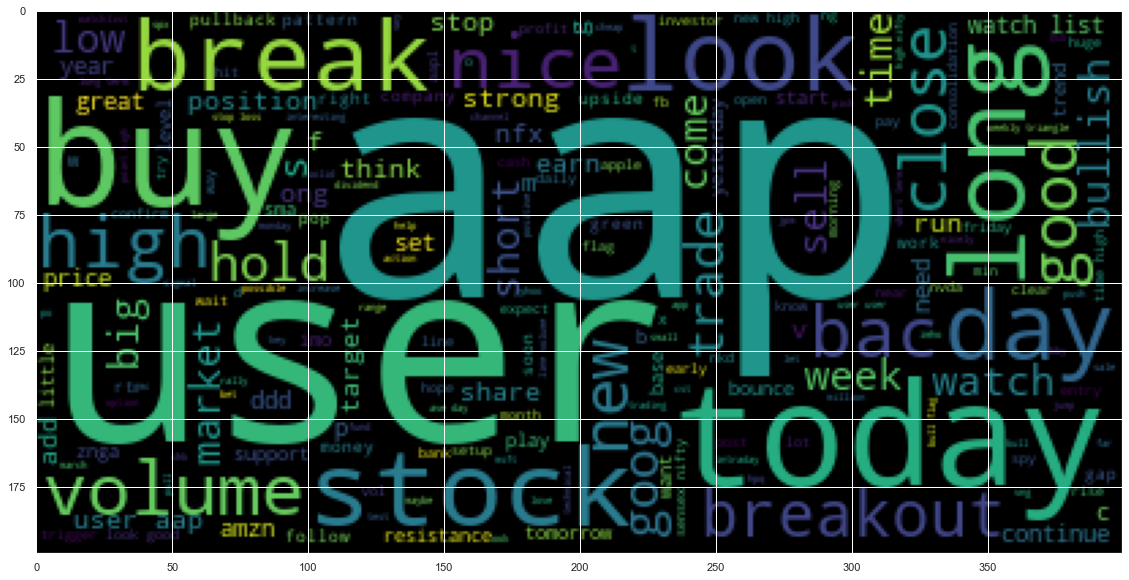

In [96]:
from wordcloud import WordCloud
plt.figure(figsize=(20,10))
plt.imshow(WordCloud().generate(textos_positivos_string))
plt.show();

In [97]:
lista_negativo = negativo['Text'].tolist()
textos_negativos_string = ' '.join(lista_negativo)
len(textos_negativos_string)

101031

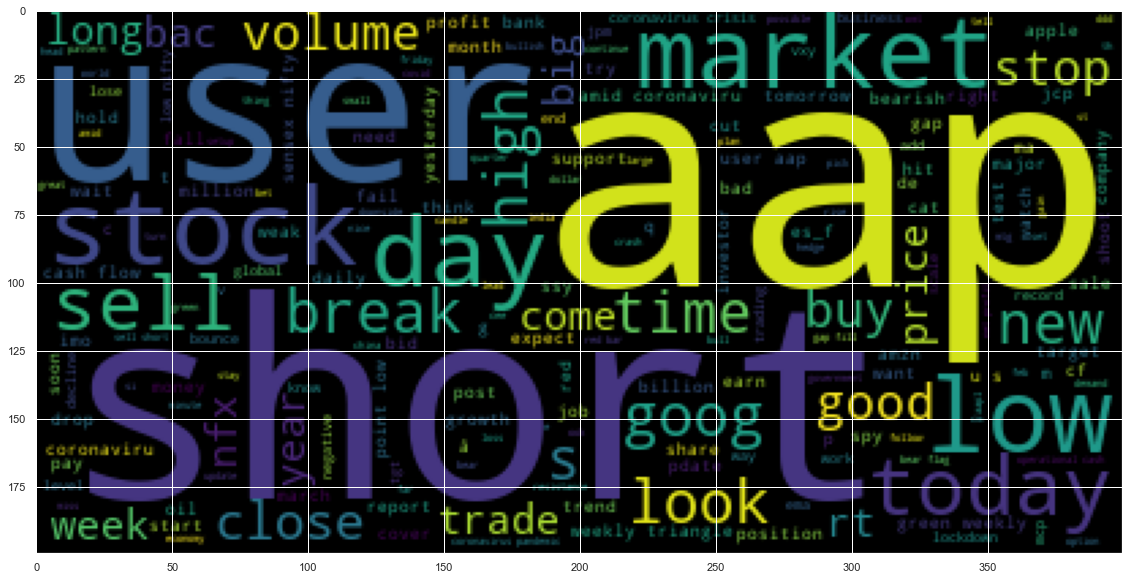

In [98]:
from wordcloud import WordCloud
plt.figure(figsize=(20,10))
plt.imshow(WordCloud().generate(textos_negativos_string))
plt.show();

## Extração de entidades nomeadas

In [99]:
documento = pln(textos_positivos_string)

In [100]:
from spacy import displacy
displacy.render(documento, style='ent', jupyter=True)

In [102]:
empresas_positivas = []
for entidade in documento.ents:
    if entidade.label_ == 'ORG':
        #print(entidade.text, entidade.label_)
        empresas_positivas.append(entidade.text)

In [106]:
empresas_positivas = set(empresas_positivas)
len(empresas_positivas)

168

In [107]:
documento = pln(textos_negativos_string)
displacy.render(documento, style='ent', jupyter=True)

In [108]:
empresas_negativas = []
for entidade in documento.ents:
    if entidade.label_ == 'ORG':
        #print(entidade.text, entidade.label_)
        empresas_negativas.append(entidade.text)
empresas_negativas = set(empresas_negativas)
len(empresas_negativas)

108

## Exercício

In [110]:
empresas_negativas_positivas = empresas_positivas.intersection(empresas_negativas)
len(empresas_negativas_positivas)

25

In [112]:
empresas_somente_positivas = empresas_positivas.difference(empresas_negativas)
len(empresas_somente_positivas)

143

In [114]:
empresas_somente_negativas = empresas_negativas.difference(empresas_positivas)
len(empresas_somente_negativas)

83

## Tratamento da base de dados

In [116]:
base.drop('tamanho', axis=1, inplace=True)
base.head()

,Text,Sentiment
0,kicker watchlist xide tit soq pnk cpw bpz aj t...,1
1,user aap movie return fea geed indicator trade...,1
2,user I afraid short amzn look like near monopo...,1
3,mnta,1
4,oi,1


In [121]:
base_train, base_test = train_test_split(base, test_size=0.3)
base_train.shape, base_test.shape

((4051, 2), (1737, 2))

In [124]:
# formato para biblioteca

base_train_final = []
for texto, sentimento in zip(base_train['Text'], base_train['Sentiment']):
    if sentimento == 1:
        dic = ({'POSITIVO':True, 'NEGATIVO': False})
    else:
        dic = ({'POSITIVO':False, 'NEGATIVO': True})
    base_train_final.append([texto, dic.copy()])

In [126]:
base_train_final[0]

['user einhorn sound like trap long I care preferred stock year aap',
 {'POSITIVO': False, 'NEGATIVO': True}]